In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
%matplotlib inline
import os

In [5]:
filename = '/home/xams/xams/PMT3_gain_calibration/P_series/P1000V_NLOFF.hdf5'

if not os.path.exists(filename):
    raise FileNotFoundError("not found")
    
store = pd.HDFStore(filename)
data= store['all_hits']
pulses = store['Pulse']
data['baseline'] = pulses[pulses['channel'] == 0]['baseline']
data['noise_sigma_adc'] = pulses[pulses['channel'] == 0]['noise_sigma']

print(len(data))
data.dtypes

1007392


Event                       int64
area                      float64
center                    float64
channel                     int64
found_in_pulse              int64
height                    float64
index_of_maximum            int64
is_rejected                  int8
left                        int64
n_saturated                 int64
noise_sigma               float64
right                       int64
sum_absolute_deviation    float64
baseline                  float32
noise_sigma_adc           float32
dtype: object

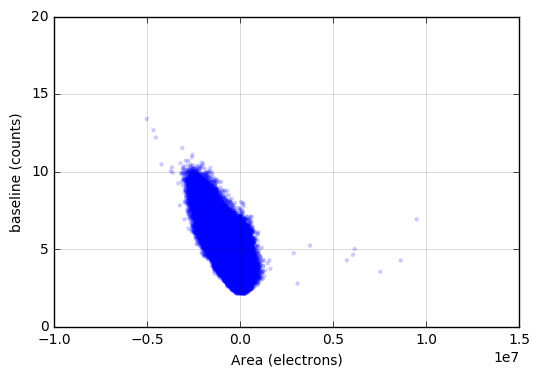

In [6]:
plt.scatter(data['area'], data['noise_sigma_adc'], edgecolor = 'none', s=10, alpha = 0.2)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel("Area (electrons)")
plt.ylabel("baseline (counts)")
plt.grid(alpha=0.2, linestyle='-')
plt.ylim([0,20])
plt.xlim([-1e7, 1.5e7])
plt.show()

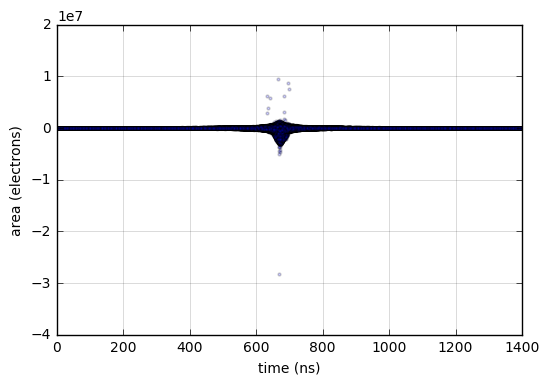

In [7]:
plt.scatter(data['center'], data['area'], s=4, alpha = 0.2)
# plt.yscale('log')
plt.xlabel("time (ns)")
plt.ylabel("area (electrons)")
plt.grid(alpha=0.2, linestyle='-')
plt.xlim([0, 1400])
plt.show()

(0.1, 1000000.0)

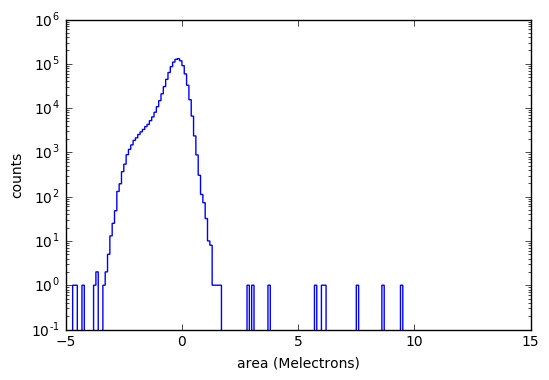

In [8]:
histboundaries = [-5, 15]
histbinwidth = 0.1
histbins = np.arange(histboundaries[0], histboundaries[1]+histbinwidth, histbinwidth)
centers = np.arange(histboundaries[0]+histbinwidth/2.0, histboundaries[1], histbinwidth)

melecs = data['area']/1e6

hist = plt.hist(melecs, bins=histbins, histtype='step')
counts = hist[0]
countserr = [np.sqrt(t)+1 for t in counts]

plt.xlabel("area (Melectrons)")
plt.ylabel("counts")
plt.yscale('log')
# plt.xlim(-1,2)
plt.ylim(1e-1,1e6)


[  1.25373195e+05  -2.38854798e-01   3.00380135e-01]
[  2.85126496e+03   5.65604939e-03   4.08283298e-03]
  
[[  8.12971187e+06   2.14863001e+00  -6.91460697e+00]
 [  2.14863001e+00   3.19908947e-05  -5.15393531e-06]
 [ -6.91460697e+00  -5.15393531e-06   1.66695251e-05]]


(1.1, 100000.0)

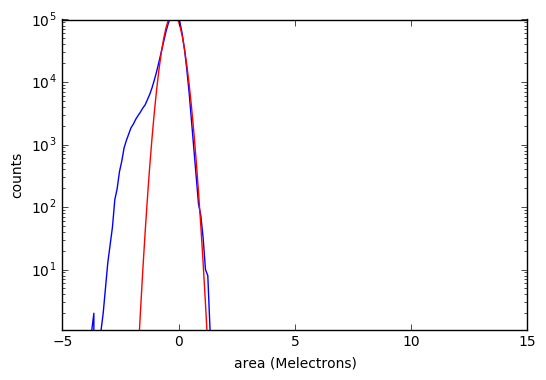

In [9]:
def gauss(x, a, b, s):
    return a * np.exp(-(x-b)**2/(2*s**2))


popt, pcov = curve_fit(gauss, centers, counts, sigma = countserr, p0 = [2400, -0.1, 0.5])
perr = np.sqrt(np.diag(pcov))

print(popt)
print(perr)
print("  ")
print(pcov)

fitcounts = [gauss(t, popt[0], popt[1], popt[2]) for t in centers]


plt.plot(centers, counts)
plt.plot(centers, fitcounts, color='red', linewidth = 1)
plt.xlabel("area (Melectrons)")
plt.ylabel("counts")
plt.yscale('log')
plt.ylim(1.1,1e5)

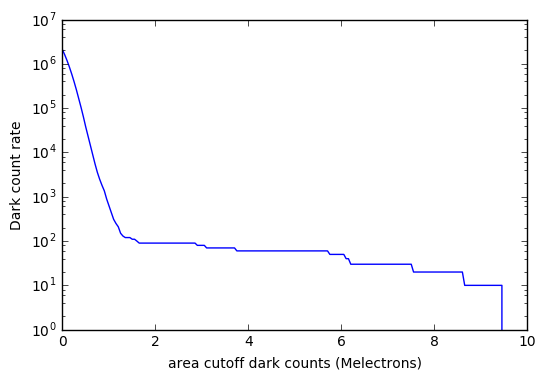

In [10]:
arealist = list(np.arange(0,10,0.05))
ratelist = [len(data[data['area'] > t*1e6])/len(data)*1e7 for t in arealist]
plt.plot(arealist, ratelist)
plt.xlabel("area cutoff dark counts (Melectrons)")
plt.ylabel("Dark count rate")
plt.yscale('log')


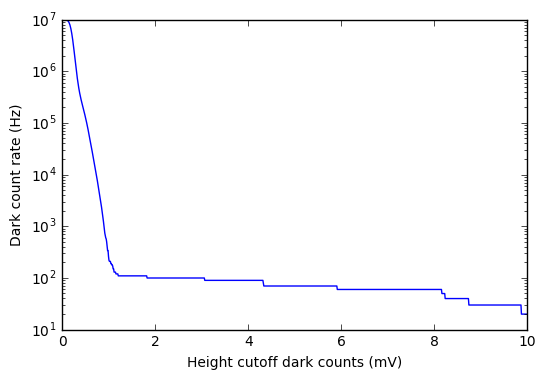

In [13]:
milvlist = list(np.arange(0,10,0.01))
conv = 1.602e-19*50/(2e-9)*10**3
ratelist = [len(data[data['height'] > t/conv])/len(data)*1e7 for t in milvlist]
plt.plot(milvlist, ratelist)
plt.xlabel("Height cutoff dark counts (mV)")
plt.ylabel("Dark count rate (Hz)")
plt.yscale('log')
plt.savefig('dark1000v.eps', format='eps')
plt.show()